# KJ: Applied Predictive Modeling 

# Linear Regression

In [1]:
# load base libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

## Exercise 6.2

Developing a model to predict permeability (see Sect. 1.4) could save significant
resources for a pharmaceutical company, while at the same time more
rapidly identifying molecules that have a sufficient permeability to become a
drug:


### A

Start R and use these commands to load the data:

> library(AppliedPredictiveModeling)
>
> data(permeability)

The matrix fingerprints contains the 1,107 binary molecular predictors
for the 165 compounds, while permeability contains permeability
response.


In [2]:
# load data from AppliedPredictiveModeling
permeability = pd.read_csv('https://raw.githubusercontent.com/NickAMC/NickAMC.github.io/main/DATA_624_S24/hw7/permeability_data.csv')
fingerprints = pd.read_csv('https://raw.githubusercontent.com/NickAMC/NickAMC.github.io/main/DATA_624_S24/hw7/fingerprints_data.csv')

In [3]:
permeability.shape, fingerprints.shape

((165, 1), (165, 1107))

The `permeability` data has 165 observations and 1 target column.

The `fingerprints` data has 165 oberservations and 1107 binary features.

In [4]:
X = fingerprints # features
y = permeability # target

### B

The fingerprint predictors indicate the presence or absence of substructures
of a molecule and are often sparse meaning that relatively few of the
molecules contain each substructure. Filter out the predictors that have
low frequencies using the nearZeroVar function from the caret package.

How many predictors are left for modeling?


Since python does not have the nearZeroVar() function, we found a feature selection function that is similar. Initially, the threshold value was not changed and found that we only remove 30 near-zero columns. So, with the updated threshold value of 0.1, we managed to reduce the number of predictors from 1 107 to 279. 

In [5]:
from sklearn.feature_selection import VarianceThreshold

def remove_near_zero_var(df, threshold = 0.1) :
     
     selector = VarianceThreshold(threshold=threshold)
     selector.fit(df)   
     high_variance_cols = df.columns[selector.get_support()]
     return df[high_variance_cols] 

In [6]:
X_filtered = remove_near_zero_var(X)

In [7]:
X_filtered.shape

(165, 279)

### C

Split the data into a training and a test set, pre-process the data, and
tune a PLS model. 

How many latent variables are optimal and what is
the corresponding resampled estimate of R2?


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size =0.2, random_state=123, shuffle=True)

In [9]:
# check for missingness
X_filtered.isna().sum().sum()

0

Due to the relatively small number of observation, the value of 5 folds seems approrpiate since having more folds will result in each fold having fewer data points for the model to learn from. Thus, it could lead to less accuarte predictions on the testing set.

In [10]:
from sklearn.model_selection import KFold
cv = KFold(n_splits = 5, shuffle=True, random_state = 123)

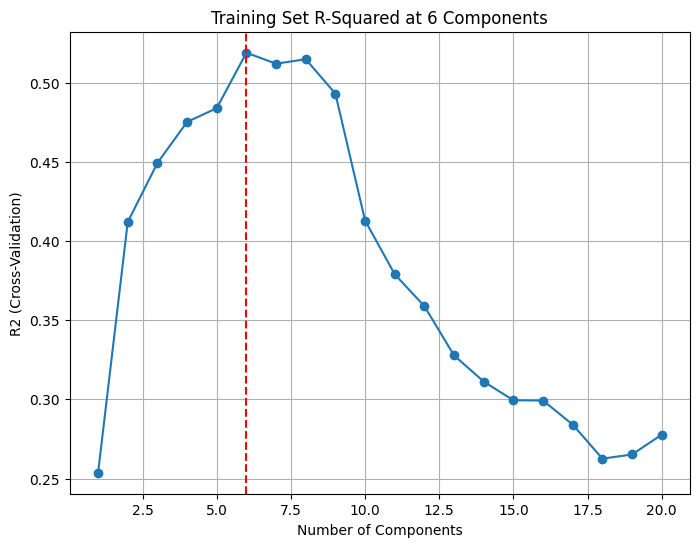

In [11]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


pls = PLSRegression()
param_grid = {'n_components': range(1, 21)} 

pls_cv = GridSearchCV(pls, param_grid, scoring='r2', cv=cv)  
pls_cv.fit(X_train, y_train)


results = pls_cv.cv_results_
optimal_n_components = pls_cv.best_params_['n_components']
best_model = pls_cv.best_estimator_
# scree plot
plt.figure(figsize=(8, 6))
plt.plot(results['param_n_components'], results['mean_test_score'], marker = 'o')
plt.xlabel('Number of Components')
plt.ylabel('R2 (Cross-Validation)')
plt.title(f"Training Set R-Squared at {optimal_n_components} Components") 
plt.grid(True)
plt.axvline(optimal_n_components, color='r', linestyle='--')
plt.show()

In [12]:
best_model

PLSRegression(n_components=6)

In [13]:
pd.DataFrame(results)[['param_n_components','mean_test_score']].sort_values(by='mean_test_score',ascending=False).head(5)

,param_n_components,mean_test_score
5,6,0.518855
7,8,0.514759
6,7,0.511922
8,9,0.492998
4,5,0.483839


The optimal number of components is 6 where it has the best relative fit on the data with a R-Squared of 0.518.

Next, to determine if this holds true for a different metric such as the RMSE. Would the number of components be the same or would it differ?

In [14]:
def rmse_score(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred)) # chagne sign since scoring in sklearn thinks that the higher the value the better


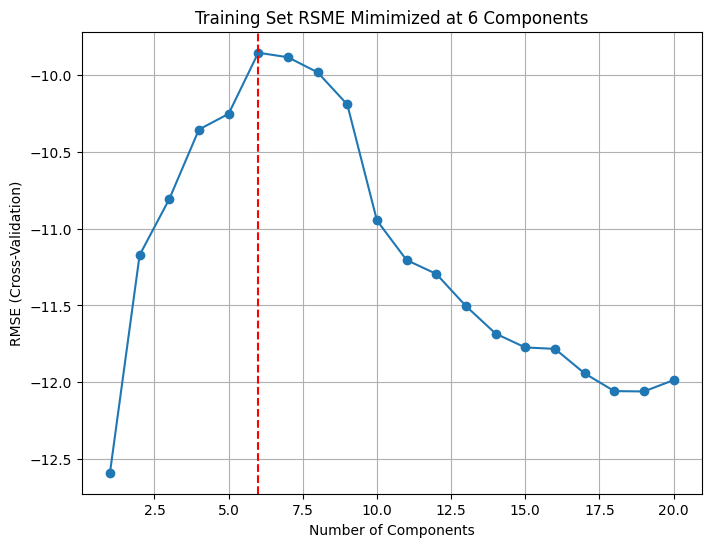

In [15]:

pls_cv = GridSearchCV(pls, param_grid, scoring=rmse_score, cv=cv, refit='RMSE')  # change scoring to from R2 to RMSE
pls_cv.fit(X_train, y_train)


results = pls_cv.cv_results_
optimal_n_components = pls_cv.best_params_['n_components']

# scree plot
plt.figure(figsize=(8, 6))
plt.plot(results['param_n_components'], results['mean_test_score'], marker = 'o')
plt.xlabel('Number of Components')
plt.ylabel('RMSE (Cross-Validation)')
plt.title(f"Training Set RSME Mimimized at {optimal_n_components} Components") 
plt.grid(True)
plt.axvline(optimal_n_components, color='r', linestyle='--')
plt.show()

In [16]:
pd.DataFrame(results)[['param_n_components','mean_test_score']].sort_values(by='mean_test_score',ascending=False).head(5)

,param_n_components,mean_test_score
5,6,-9.854153
6,7,-9.883697
7,8,-9.982038
8,9,-10.191270
4,5,-10.252059


The optimal number of components of the PLSRegression in terms of the RMSE is minimized at 6 components. Thus, the optimal PLS model has 6 componentns which is based on the metrics of R-Squared and RMSE.

In addition, the experimentation with scaled X_train using the StandardScaler() from sklearn demonstatration no significant impact on the test scores. So, leaving the X values unscaled for modeling.

### D

Predict the response for the test set. What is the test set estimate of R2?


From cross-validation, 6 components provide the best performance metrics.

In [17]:
plsr = PLSRegression(n_components=6)
plsr.fit(X_train, y_train)
y_pred = plsr.predict(X_test)

In [18]:
from sklearn.metrics import r2_score

plsr_r2 = r2_score(y_test, y_pred)
print(f'R-squared of the test set: {plsr_r2}')

R-squared of the test set: 0.22044523464989485


### E

Try building other models discussed in this chapter. 

Do any have better
predictive performance?


In [19]:
# PCA Regression
# perform  PCA first then fit to LinearRegrssion model

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

pipe = Pipeline([('pca', PCA()), ('linear regression',  LinearRegression())])
param_grid = {
    'pca__n_components': range(1, 40) 
}
scoring = make_scorer(mean_squared_error, greater_is_better=False)

pca_cv = GridSearchCV(pipe, param_grid, scoring=scoring, cv=cv, refit='mean_squared_error') 
pca_cv.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('linear regression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': range(1, 40)},
             refit='mean_squared_error',
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'))

In [20]:
optimal_n_components_pca = pca_cv.best_params_['pca__n_components']
print(f"Optimal Number of Components:{optimal_n_components_pca}")

Optimal Number of Components:26


In [21]:
results_df = pd.DataFrame(pca_cv.cv_results_)[['param_pca__n_components', 'mean_test_score']]

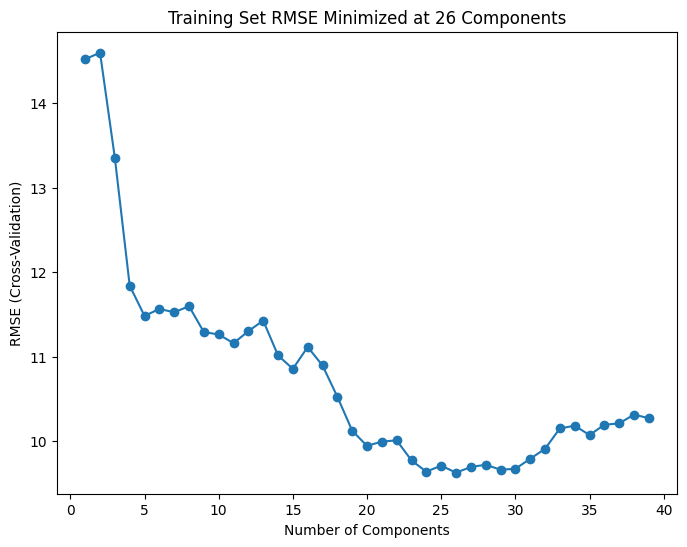

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(results_df.param_pca__n_components, np.sqrt(-results_df.mean_test_score), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('RMSE (Cross-Validation)')
plt.title(f"Training Set RMSE Minimized at {optimal_n_components_pca} Components") 
plt.show()

In [23]:
pca = PCA(n_components  = 26)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lm = LinearRegression()
lm.fit(X_train_pca, y_train)

y_pred = lm.predict(X_test_pca)


In [24]:
pcr_r2= r2_score(y_test, y_pred)
print(f'R-squared of the test set: {pcr_r2}')

R-squared of the test set: 0.29587680000513394


In [25]:
# Penalized Regressions
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

param_grid = {'alpha': range(1,20)}  # values of alpha to try. dont include 0 since that would make a regular linear regression i.e. the bias term is zero

ridge_model = Ridge()

grid_search = GridSearchCV(ridge_model, param_grid, scoring=scoring, cv=cv, refit='neg_mean_squared_error')
grid_search.fit(X_train, y_train) 

best_alpha = grid_search.best_params_['alpha']
print("Best Alpha:", best_alpha) 

Best Alpha: 11


In [26]:
# find the best parametere for lasso 

lasso_model = Lasso()
grid_search = GridSearchCV(lasso_model, param_grid, scoring=scoring, cv=cv, refit='neg_mean_squared_error')
grid_search.fit(X_train, y_train) 

best_alpha = grid_search.best_params_['alpha']
print("Best Alpha:", best_alpha) 


Best Alpha: 1


In [27]:
param_grid_elasticnet = {'alpha': range(1,20)} 
elasticnet_model = ElasticNet()
grid_search = GridSearchCV(elasticnet_model, param_grid_elasticnet, scoring=scoring, cv=cv, refit='neg_mean_squared_error')
grid_search.fit(X_train, y_train) 

best_alpha = grid_search.best_params_['alpha']

print("Best Alpha:", best_alpha)


Best Alpha: 1


In [28]:
#| message : false
#| warning : false
param_grid_l1 = {'l1_ratio' : np.arange(0,1,0.1)}
elasticnet_model = ElasticNet(alpha=1) # set alpha to 1
grid_search = GridSearchCV(elasticnet_model, param_grid_l1, scoring=scoring, cv=cv, refit='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_l1 = grid_search.best_params_['l1_ratio']


c:\Users\nickc\DataScience\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.900e+03, tolerance: 2.225e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\nickc\DataScience\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.108e+03, tolerance: 2.364e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented 

In [29]:

print("Best L1_ratio:", best_l1)


Best L1_ratio: 0.0


In [30]:
#| message : false
#| warning : false

ridge_model = Ridge(alpha=11)
ridge_model.fit(X_train,y_train)
ridge_preds = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train,y_train)
lasso_preds = lasso_model.predict(X_test)

elastic_model = ElasticNet(alpha=1, l1_ratio=0) # basically a ridge regression since l1_ratio is zero
elastic_model.fit(X_train,y_train)
elastic_preds = elastic_model.predict(X_test)

c:\Users\nickc\DataScience\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.730e+03, tolerance: 2.940e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [31]:
print(f'PLS Model R-squared: {plsr_r2}')
print(f'PCA Regression R-squared: {pcr_r2}')
print(f'Ridge Model R-squared : {r2_score(y_test, ridge_preds)}')
print(f'Lasso Model R-squared : {r2_score(y_test, lasso_preds)}')
print(f'Elastic Model R-squared : {r2_score(y_test, elastic_preds)}')


PLS Model R-squared: 0.22044523464989485
PCA Regression R-squared: 0.29587680000513394
Ridge Model R-squared : 0.2188316862106522
Lasso Model R-squared : 0.21291778419736995
Elastic Model R-squared : 0.2031244000136866


### F

Would you recommend any of your models to replace the permeability
laboratory experiment?




The current models do not have the predictive power to accurately predict permeabilitly. THeire R-squared values of 0.2-0.3 indicate a weak fit of the data meaning that a lot of the characterisitics of the data remain uncaptured by the models.

___

## Exercise 6.3

A chemical manufacturing process for a pharmaceutical product was
discussed in Sect. 1.4. 

In this problem, the objective is to understand the relationship
between biological measurements of the raw materials (predictors),measurements of the manufacturing process (predictors), and the response of
product yield. Biological predictors cannot be changed but can be used to
assess the quality of the raw material before processing. 

On the other hand,
manufacturing process predictors can be changed in the manufacturing process.
Improving product yield by 1% will boost revenue by approximately
one hundred thousand dollars per batch:


### A 

Start R and use these commands to load the data:

> library(AppliedPredictiveModeling)
>
> data(chemicalManufacturing)

The matrix processPredictors contains the 57 predictors (12 describing
the input biological material and 45 describing the process predictors)
for the 176 manufacturing runs. yield contains the percent yield for each
run.



In [32]:
chemical_df = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/hw7/chemical_data.csv').drop('Unnamed: 0',axis=1)

In [33]:
chemical_df

,Yield,BiologicalMaterial01,BiologicalMaterial02,BiologicalMaterial03,BiologicalMaterial04,BiologicalMaterial05,BiologicalMaterial06,BiologicalMaterial07,BiologicalMaterial08,BiologicalMaterial09,...,ManufacturingProcess36,ManufacturingProcess37,ManufacturingProcess38,ManufacturingProcess39,ManufacturingProcess40,ManufacturingProcess41,ManufacturingProcess42,ManufacturingProcess43,ManufacturingProcess44,ManufacturingProcess45
0,38.00,6.25,49.58,56.97,12.74,19.51,43.73,100.0,16.66,11.44,...,0.019,0.5,3,7.2,NaN,NaN,11.6,3.0,1.8,2.4
1,42.44,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.019,2.0,2,7.2,0.1,0.15,11.1,0.9,1.9,2.2
2,42.03,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.018,0.7,2,7.2,0.0,0.00,12.0,1.0,1.8,2.3
3,41.42,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.018,1.2,2,7.2,0.0,0.00,10.6,1.1,1.8,2.1
4,42.49,7.47,63.33,72.25,14.02,17.91,54.66,100.0,18.22,12.80,...,0.017,0.2,2,7.3,0.0,0.00,11.0,1.1,1.7,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,39.66,6.71,56.32,66.19,12.35,20.02,50.26,100.0,17.54,12.50,...,NaN,2.3,0,0.0,0.0,0.00,0.0,0.6,0.0,0.0
172,39.68,6.87,56.74,66.61,12.55,20.18,50.80,100.0,17.48,12.41,...,NaN,1.0,0,0.0,0.0,0.00,0.0,0.6,0.0,0.0
173,42.23,7.50,58.41,68.30,13.33,20.81,52.96,100.0,17.23,12.04,...,NaN,1.3,0,0.0,0.0,0.00,0.0,0.6,0.0,0.0
174,38.48,7.53,58.36,69.25,14.35,20.57,51.31,100.0,17.87,12.77,...,NaN,2.3,0,0.0,0.0,0.00,0.0,0.5,0.0,0.0


### B

A small percentage of cells in the predictor set contain missing values. 

Use
an imputation function to fill in these missing values (e.g., see Sect. 3.8).



In [34]:
X = chemical_df.drop('Yield', axis=1)
y = chemical_df[['Yield']]

In [35]:
X.shape, y.shape

((176, 57), (176, 1))

In [36]:
# check for missingnes
X.isna().sum().sum()

106

There are 106 missing values to impute with median. Using median is more robust than mean and preferred since it less impact of the distribution of the data.

In [37]:
X.fillna(X.median(), inplace=True)


### C

Split the data into a training and a test set, pre-process the data, and
tune a model of your choice from this chapter. 

What is the optimal value
of the performance metric?



Since the each feature has on a unique scale, standard scaling is required to ensure that features equallycontribute to the model leading to a unbiased model.

In [38]:
X_filtered = remove_near_zero_var(X, threshold=0.2) # removes variance less than 0.2

In [39]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)
X_scaled_df = pd.DataFrame(X_scaled, columns = X_filtered.columns)

In [43]:
chem_man_pp_df = pd.concat([X_scaled_df, pd.DataFrame(y)], axis=1)
chem_man_pp_df.to_csv('chem_man_pp_data.csv', index=False)


In [40]:
# mean should be around 0 and std to be 1
np.mean(X_scaled), np.std(X_scaled)

(-1.0092936587501423e-16, 1.0)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size = 0.2, shuffle = True, random_state=1234)

In [42]:
X_scaled_df.shape, X_pca_scaled.shape

NameError: name 'X_pca_scaled' is not defined

In [ ]:
pls = PLSRegression()

param_grid = {
    'n_components': range(1, 20)  
}

grid_search = GridSearchCV(pls, param_grid, scoring='r2', cv=cv, refit='mean_squared_error')
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_
optimal_n_components = pls_cv.best_params_['n_components']


best_n_components = grid_search.best_params_['n_components']
best_r2 = grid_search.best_score_
print("Optimal Number of Components:", best_n_components)
print("Best R2:", best_r2)
results_df = pd.DataFrame(results)

Optimal Number of Components: 4
Best R2: 0.4107344665711775


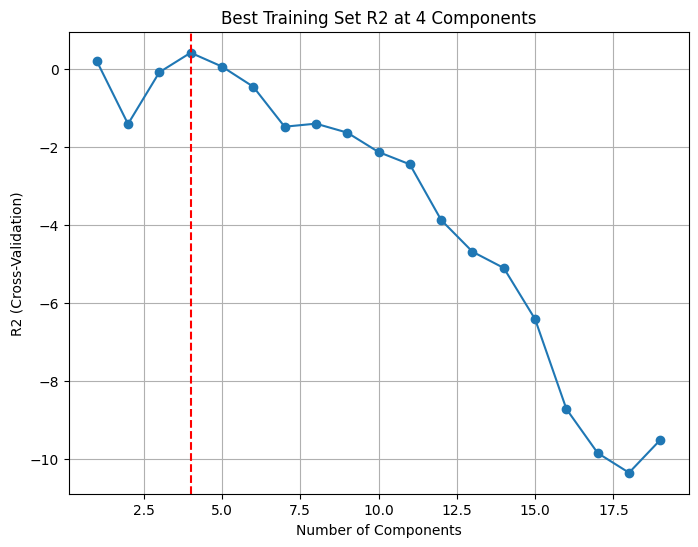

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(results_df.param_n_components, results_df.mean_test_score, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('R2 (Cross-Validation)')
plt.title(f"Best Training Set R2 at {best_n_components} Components")
plt.axvline(best_n_components, color='r', linestyle='--') 
plt.grid()
plt.show()

In [ ]:
grid_search = GridSearchCV(pls, param_grid, scoring=scoring, cv=cv, refit='neg_mean_squared_error')  
grid_search.fit(X_train, y_train) 

results = pd.DataFrame(grid_search.cv_results_)

best_n_components = grid_search.best_params_['n_components']
best_rmse = np.sqrt(-grid_search.best_score_) # dont forget to convert back to RMSE
print("Optimal Number of Components:", best_n_components)
print("Best RMSE:", best_rmse)

Optimal Number of Components: 4
Best RMSE: 1.3248062816568802


### D 

Predict the response for the test set.What is the value of the performance
metric and how does this compare with the resampled performance metric
on the training set?



In [ ]:
pls_model = PLSRegression(n_components=4)

pls_model.fit(X_train,y_train)
y_pred = pls_model.predict(X_test)

print(f'RMSE: {mean_squared_error(y_test,y_pred)}')

RMSE: 1.547730653575556


Comparing the RMSE from cross validation set is not too different from the RMSE on the test set. Suggests that the model learned the underlying patterns beyond the folds during cross validation.

Guess, this particular company has fine-tuned its manufacturing process so much that the quality of the biological material has less impact of the yield of the product.

### E 

Which predictors are most important in the model you have trained?

Do either the biological or process predictors dominate the list?



In [ ]:
coef_df = pd.DataFrame(pls_model.coef_, columns = X_train.columns).T
coef_df.columns = ['Importance']
coef_df = coef_df.sort_values('Importance', ascending = False).reset_index()


In [ ]:
coef_df.columns

Index(['index', 'Importance'], dtype='object')

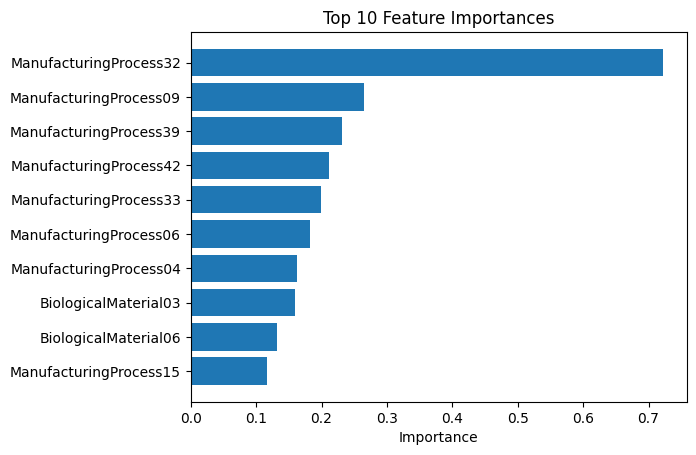

In [ ]:
plt.barh(coef_df['index'].head(10), coef_df['Importance'].head(10)) 
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

The manufacturing process is mainly responsible to the amount of product yield this chemical company produces. Meaning that improving  product yield can be done by optimizing the manufacturing process rather than the quantity of the biological materials. 

### F

Explore the relationships between each of the top predictors and the response.

How could this information be helpful in improving yield in future
runs of the manufacturing process?

In [ ]:
feature_names = coef_df['index'].head(10).tolist()

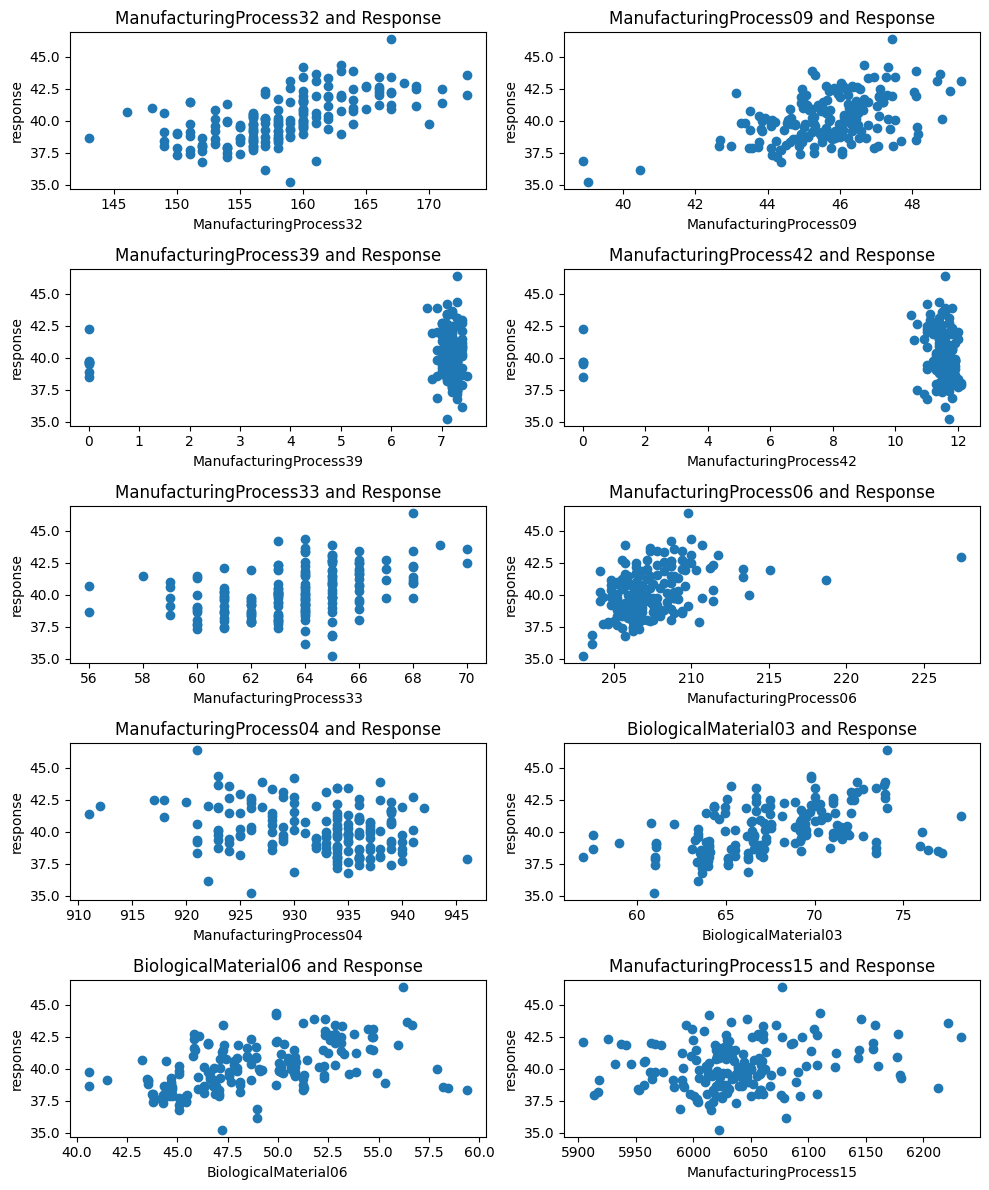

In [ ]:
num_plots = len(feature_names)
rows = 5
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, feature in enumerate(feature_names):
    row = i // cols
    col = i % cols
    axes[row, col].scatter(X[feature], y['Yield'])
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('response')
    axes[row, col].set_title(f'{feature} and Response')

plt.tight_layout()
plt.show()

This information can be helpful in improving yield in future by finding out which manufacturing process and biological process impacts the value of the yield the most. Some of processes such as MP32 and MP3 have a positive correlation with out target variable which suggests that improving those specific preocesses will in turn improve yields. Furthermore, taking a look at MP39 and MP 42 its seems that their values has high variability for the same input. 